<a href="https://colab.research.google.com/github/northwestWebbs/UAS_Deep-Learning_Kelompok-1-Studi-Kasus-3-Analisis-sentimen-ulasan-produk-dengan-BERT-/blob/main/Deep_Learning_Kel_1_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U transformers

In [ ]:
from google.colab import files
uploaded = files.upload()

DATA_PATH = list(uploaded.keys())[0]
print(f"Dataset berhasil diupload: {DATA_PATH}")

Saving Dataset Review Product di Shopee dan Tokopedia.csv to Dataset Review Product di Shopee dan Tokopedia.csv
Dataset berhasil diupload: Dataset Review Product di Shopee dan Tokopedia.csv


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
OUT_DIR = "./model_output"
os.makedirs(OUT_DIR, exist_ok=True)

SEED = 42
MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
RANDOM_STATE = SEED

In [ ]:
df = pd.read_csv(DATA_PATH, encoding='latin-1', delimiter=';')

def label_sentiment(rating):
    if rating >= 4:
        return "positif"
    elif rating <= 2:
        return "negatif"
    else:
        return None

df['sentiment'] = df['rating'].apply(label_sentiment)

df = df.dropna(subset=['sentiment', 'review'])

label2id = {"negatif": 0, "positif": 1}
id2label = {0: "negatif", 1: "positif"}
df['label'] = df['sentiment'].map(label2id)

print("Distribusi Label:")
print(df['sentiment'].value_counts())

Distribusi Label:
sentiment
positif    40605
negatif    11903
Name: count, dtype: int64


In [ ]:
train_df, test_df = train_test_split(
    df[['review', 'label']],
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

hf_train = Dataset.from_pandas(train_df)
hf_test = Dataset.from_pandas(test_df)
dataset = DatasetDict({"train": hf_train, "test": hf_test})

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    return tokenizer(examples['review'], truncation=True, max_length=MAX_LENGTH)

dataset = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/42006 [00:00<?, ? examples/s]

Map:   0%|          | 0/10502 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"
from sklearn.metrics import accuracy_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import BertForSequenceClassification, BertTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import files

# Define variables used in TrainingArguments
OUT_DIR = "./model_output"
SEED = 42
MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
RANDOM_STATE = SEED
MODEL_NAME = "indobenchmark/indobert-base-p1"

# Upload the dataset
uploaded = files.upload()
DATA_PATH = list(uploaded.keys())[0]
print(f"Dataset berhasil diupload: {DATA_PATH}")

# Define label mappings
label2id = {"negatif": 0, "positif": 1}
id2label = {0: "negatif", 1: "positif"}

# Load and preprocess data
df = pd.read_csv(DATA_PATH, encoding='latin-1', delimiter=';')

def label_sentiment(rating):
    if rating >= 4:
        return "positif"
    elif rating <= 2:
        return "negatif"
    else:
        return None

df['sentiment'] = df['rating'].apply(label_sentiment)
df = df.dropna(subset=['sentiment', 'review'])
df['label'] = df['sentiment'].map(label2id)

train_df, test_df = train_test_split(
    df[['review', 'label']],
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

hf_train = Dataset.from_pandas(train_df)
hf_test = Dataset.from_pandas(test_df)
dataset = DatasetDict({"train": hf_train, "test": hf_test})

# Initialize tokenizer and preprocess dataset
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    return tokenizer(examples['review'], truncation=True, max_length=MAX_LENGTH)

dataset = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Load the model
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    logging_dir=f"{OUT_DIR}/logs",
    seed=SEED,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate(dataset["test"])
print(metrics)

Saving Dataset Review Product di Shopee dan Tokopedia.csv to Dataset Review Product di Shopee dan Tokopedia (1).csv
Dataset berhasil diupload: Dataset Review Product di Shopee dan Tokopedia (1).csv


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/42006 [00:00<?, ? examples/s]

Map:   0%|          | 0/10502 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2288680529.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.281400
1000,0.248100
1500,0.229100
2000,0.208200
2500,0.204500
3000,0.169600
3500,0.174600
4000,0.160900
4500,0.160900
5000,0.160700


{'eval_loss': 0.2455058991909027, 'eval_accuracy': 0.9339173490763664, 'eval_f1': 0.9573395623309565, 'eval_runtime': 47.7178, 'eval_samples_per_second': 220.086, 'eval_steps_per_second': 13.768, 'epoch': 3.0}



Classification Report:
              precision    recall  f1-score   support

     negatif       0.86      0.85      0.85      2381
     positif       0.96      0.96      0.96      8121

    accuracy                           0.93     10502
   macro avg       0.91      0.90      0.91     10502
weighted avg       0.93      0.93      0.93     10502



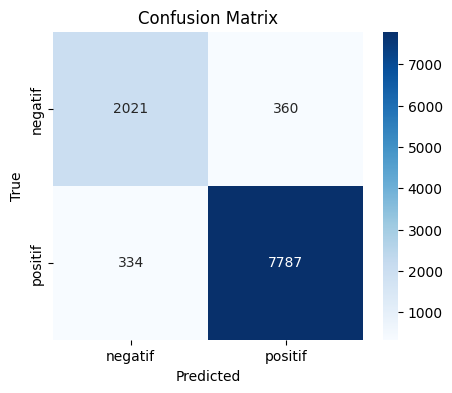

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)

print("\nClassification Report:")
print(classification_report(dataset["test"]['label'], preds, target_names=[str(k) for k in id2label.values()]))

cm = confusion_matrix(dataset["test"]['label'], preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negatif", "positif"],
            yticklabels=["negatif", "positif"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

pred_df = dataset["test"].to_pandas()
pred_df['predicted'] = preds
pred_df['predicted_label'] = pred_df['predicted'].map(id2label)
pred_df.to_csv(os.path.join(OUT_DIR, "predictions.csv"), index=False)

print(f"\n✅ Model dan hasil prediksi disimpan di: {OUT_DIR}")


✅ Model dan hasil prediksi disimpan di: ./model_output


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = accuracy_score(dataset["test"]['label'], preds)
print("Akurasi:", accuracy)

print(classification_report(dataset["test"]['label'], preds))

Akurasi: 0.9339173490763664
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2381
           1       0.96      0.96      0.96      8121

    accuracy                           0.93     10502
   macro avg       0.91      0.90      0.91     10502
weighted avg       0.93      0.93      0.93     10502



/tmp/ipython-input-229947986.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_label', data=pred_df, palette='viridis')


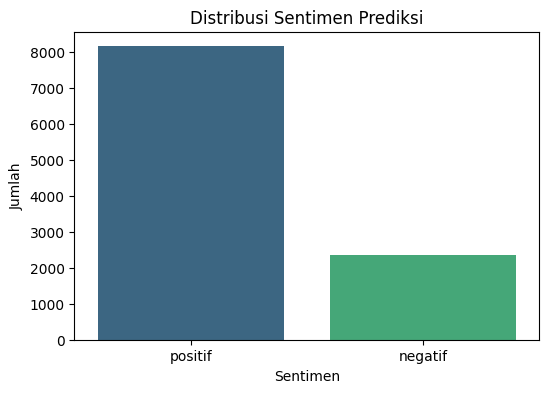

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='predicted_label', data=pred_df, palette='viridis')
plt.title('Distribusi Sentimen Prediksi')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()